In [20]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from tqdm.notebook import tqdm

In [21]:
#create a pandas dataframes from csv files
users = pd.read_csv('new_users.csv', lineterminator='\n', index_col=0)
#tweets = pd.read_csv('new_tweets.csv', lineterminator='\n', index_col=0)
users.head(2)

,user_id,name,lang,bot,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,...,tweets_per_year,activity_period,Bot_Entropy,sub_year,sub_month,sub_day,retweet_max,reply_max,favorite_max,interaction_count
0,2353593986,Lamonica Raborn,en,1,132,132,5,0,5,13,...,22.000000,5,0.001426,2019,2,22,1.0,0.0,1.0,9
1,2358850842,Lourie Botton,en,0,122,122,3,0,6,4,...,20.333333,5,NaN,2019,2,26,1.0,0.0,1.0,9


In [22]:
users_clean = users.drop(columns= ['lang', 'name','user_id','Bot_Entropy'] , axis=1)
users_clean.head(5)

,bot,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,urls_used,mentions_used,favorite_avg,...,avg_lenght,tweets_per_year,activity_period,sub_year,sub_month,sub_day,retweet_max,reply_max,favorite_max,interaction_count
0,1,132,132,5,0,5,13,0,37,0.04,...,62,22.000000,5,2019,2,22,1.0,0.0,1.0,9
1,0,122,122,3,0,6,4,0,41,0.05,...,69,20.333333,5,2019,2,26,1.0,0.0,1.0,9
2,1,1439,1439,1190,0,259,107,36,9,0.18,...,87,179.875000,30,2017,1,18,364.0,0.0,11.0,238
3,0,7085,3656,62,0,226,479,3,1936,0.06,...,72,731.200000,4,2019,6,18,3.0,0.0,2.0,246
4,0,7406,2081,31810,0,1260,54,60,1908,0.61,...,45,260.125000,19,2018,11,19,390.0,0.0,12.0,1643


## Correlation Analysis

In [23]:
# from sklearn.metrics.pairwise import euclidean_distances
# distance_matrix = euclidean_distances(users_clean, users_clean)
# ax = sns.heatmap(distance_matrix)
# plt.figure(figsize = (10,10))
# plt.show()

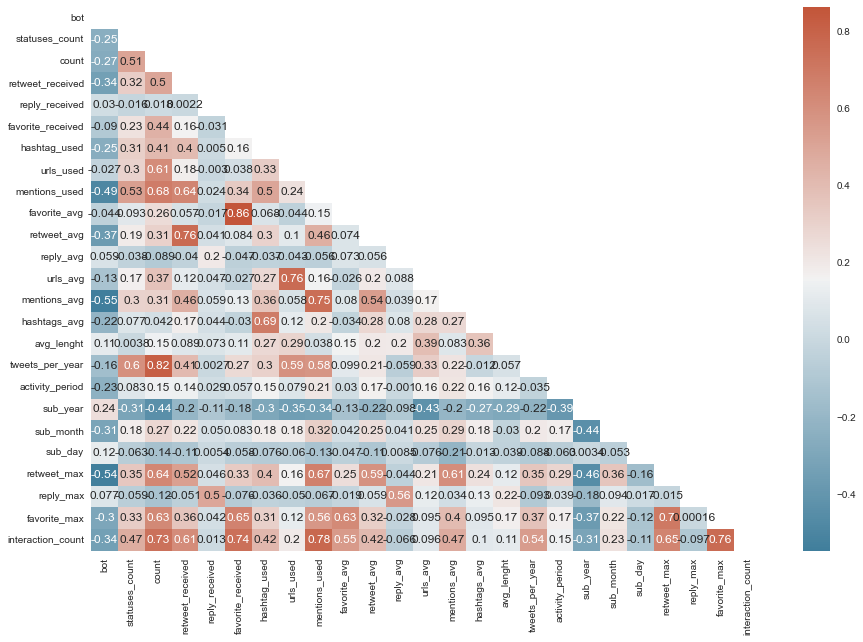

In [24]:
plt.figure(figsize=(15,10))

a = users_clean.corr()
mask = np.triu(np.ones_like(a, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(a, annot=True, mask = mask, cmap=cmap)

plt.show()

In [25]:
corr_threshold = 0.7
print("Att. A\t\t\tAtt. B\t\t\tCorr(A,B)")
for i in range(0, len(users_clean.columns)):
    for j in range(i+1, len(users_clean.columns)):
        corr = users_clean[users_clean.columns[i]].corr(users_clean[users_clean.columns[j]])
        if  corr > corr_threshold:
            print(users_clean.columns[i] + "\t\t\t" + users_clean.columns[j] + "\t\t\t" + '{:.4f}'.format(corr))

Att. A			Att. B			Corr(A,B)
count			tweets_per_year			0.8163
count			interaction_count			0.7310
retweet_received			retweet_avg			0.7584
favorite_received			favorite_avg			0.8628
favorite_received			interaction_count			0.7411
urls_used			urls_avg			0.7589
mentions_used			mentions_avg			0.7489
mentions_used			interaction_count			0.7781
retweet_max			favorite_max			0.7020
favorite_max			interaction_count			0.7603


In [26]:
dropping_column = ['statuses_count', 'favorite_max', 'sub_year', 'sub_day', 'sub_month', 'count', 'favorite_received', 'retweet_received', 'mentions_used', 'reply_received', 'hashtag_used', 'urls_used', 'bot']

In [27]:
users_clean = users_clean.drop(columns=dropping_column)

# Kmeans Clustering

### Find best k

In [28]:
users_clean.head()

,favorite_avg,retweet_avg,reply_avg,urls_avg,mentions_avg,hashtags_avg,avg_lenght,tweets_per_year,activity_period,retweet_max,reply_max,interaction_count
0,0.04,0.04,0.0,0.00,0.28,0.10,62,22.000000,5,1.0,0.0,9
1,0.05,0.02,0.0,0.00,0.34,0.03,69,20.333333,5,1.0,0.0,9
2,0.18,0.83,0.0,0.03,0.01,0.07,87,179.875000,30,364.0,0.0,238
3,0.06,0.02,0.0,0.00,0.53,0.13,72,731.200000,4,3.0,0.0,246
4,0.61,15.29,0.0,0.03,0.92,0.03,45,260.125000,19,390.0,0.0,1643


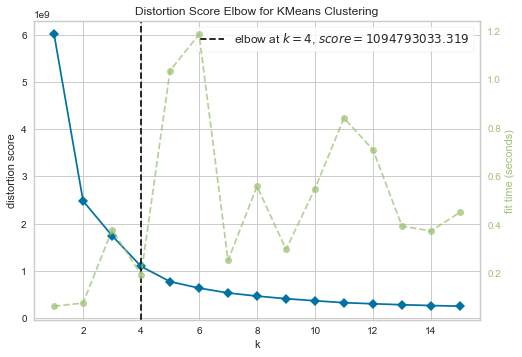

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,16), metric="distortion")

visualizer.fit(users_clean)        # Fit the data to the visualizer
visualizer.show()                  # Finalize and render the figure

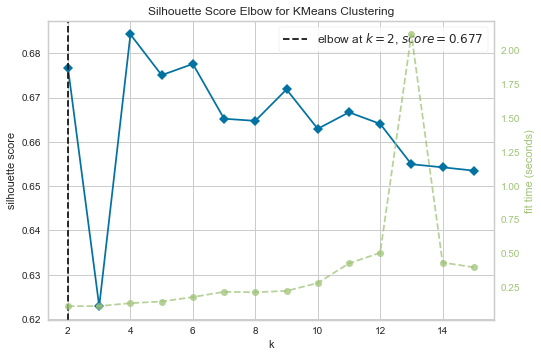

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [30]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16), metric="silhouette")

visualizer.fit(users_clean)        # Fit the data to the visualizer
visualizer.show()

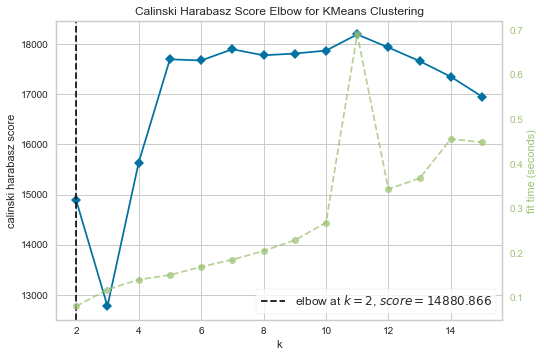

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [31]:
# Instantiate the clustering model and visualizer with 
# ratio of within to between cluster dispersion (calinski_harabasz)

#model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16), metric="calinski_harabasz")

visualizer.fit(users_clean)
visualizer.show()

In [32]:
sse_list = list()
sil_list = list()
k_cols = []

max_k = 16
for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Iterating over possible K values"):
    kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans_iter.fit(users_clean)     
    sil_list.append(silhouette_score(users_clean, kmeans_iter.labels_))
    sse = int(kmeans_iter.inertia_)
    sse_list.append(sse)
    k_cols.append(str(k))
    
store_results=pd.DataFrame()
store_results['K'] = k_cols
store_results['SSE'] = sse_list
store_results['Silhouette'] = sil_list
store_results.set_index(['K'], inplace=True)
store_results

Iterating over possible K values:   0%|          | 0/15 [00:00<?, ?it/s]

,SSE,Silhouette
K,,
2,2479329175,0.676687
3,1745184823,0.622851
4,1094796177,0.684246
5,772838070,0.675052
6,635295905,0.677591
7,532722872,0.665226
8,465277963,0.664842
9,410361070,0.671880
10,366313841,0.663391


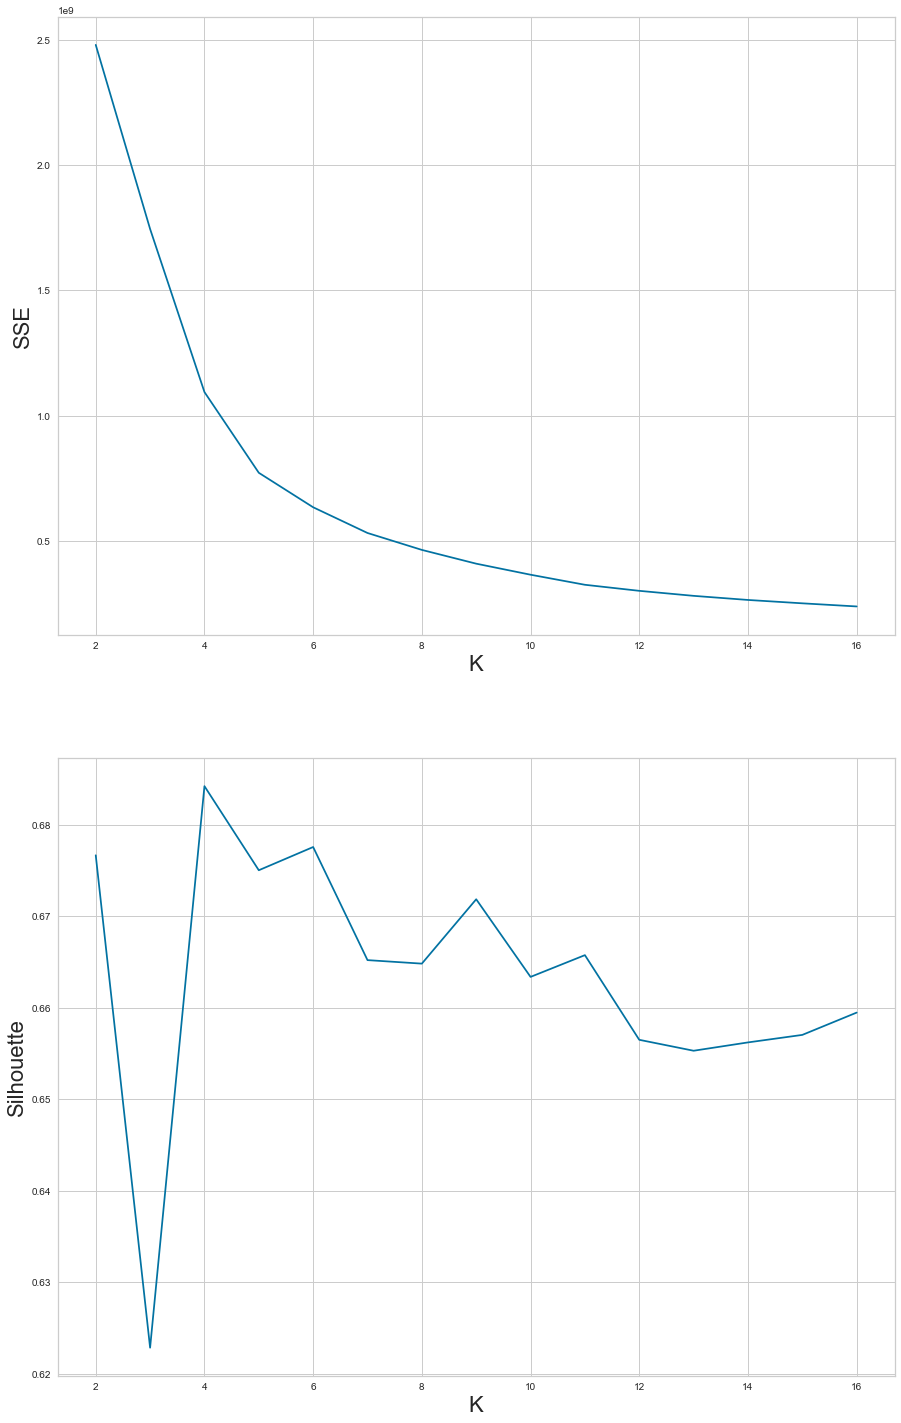

In [39]:
fig, axs = plt.subplots(2,1,figsize=(15,25))
axs[0].plot(range(2, len(sse_list) + 2), sse_list)
axs[0].set_ylabel('SSE', fontsize=22)
axs[0].set_xlabel('K', fontsize=22)
axs[0].tick_params(axis='both', which='major', labelsize=10)

axs[1].plot(range(2, len(sil_list) + 2), sil_list)
axs[1].set_ylabel('Silhouette', fontsize=22)
axs[1].set_xlabel('K', fontsize=22)
axs[1].tick_params(axis='both', which='major', labelsize=10)

In [33]:
clustering_numbers = 4

### Apply KMEANS

In [34]:
scaler = MinMaxScaler()
X = scaler.fit_transform(users_clean.values)

In [35]:
# calculate the cluster
kmeans = KMeans(clustering_numbers, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=4)

In [36]:
# print the unique labels identified by K-Means
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([1169, 6447,  235, 2607]))

In [37]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
dict(zip(bins, hist))

{0: 1169, 1: 6447, 2: 235, 3: 2607}

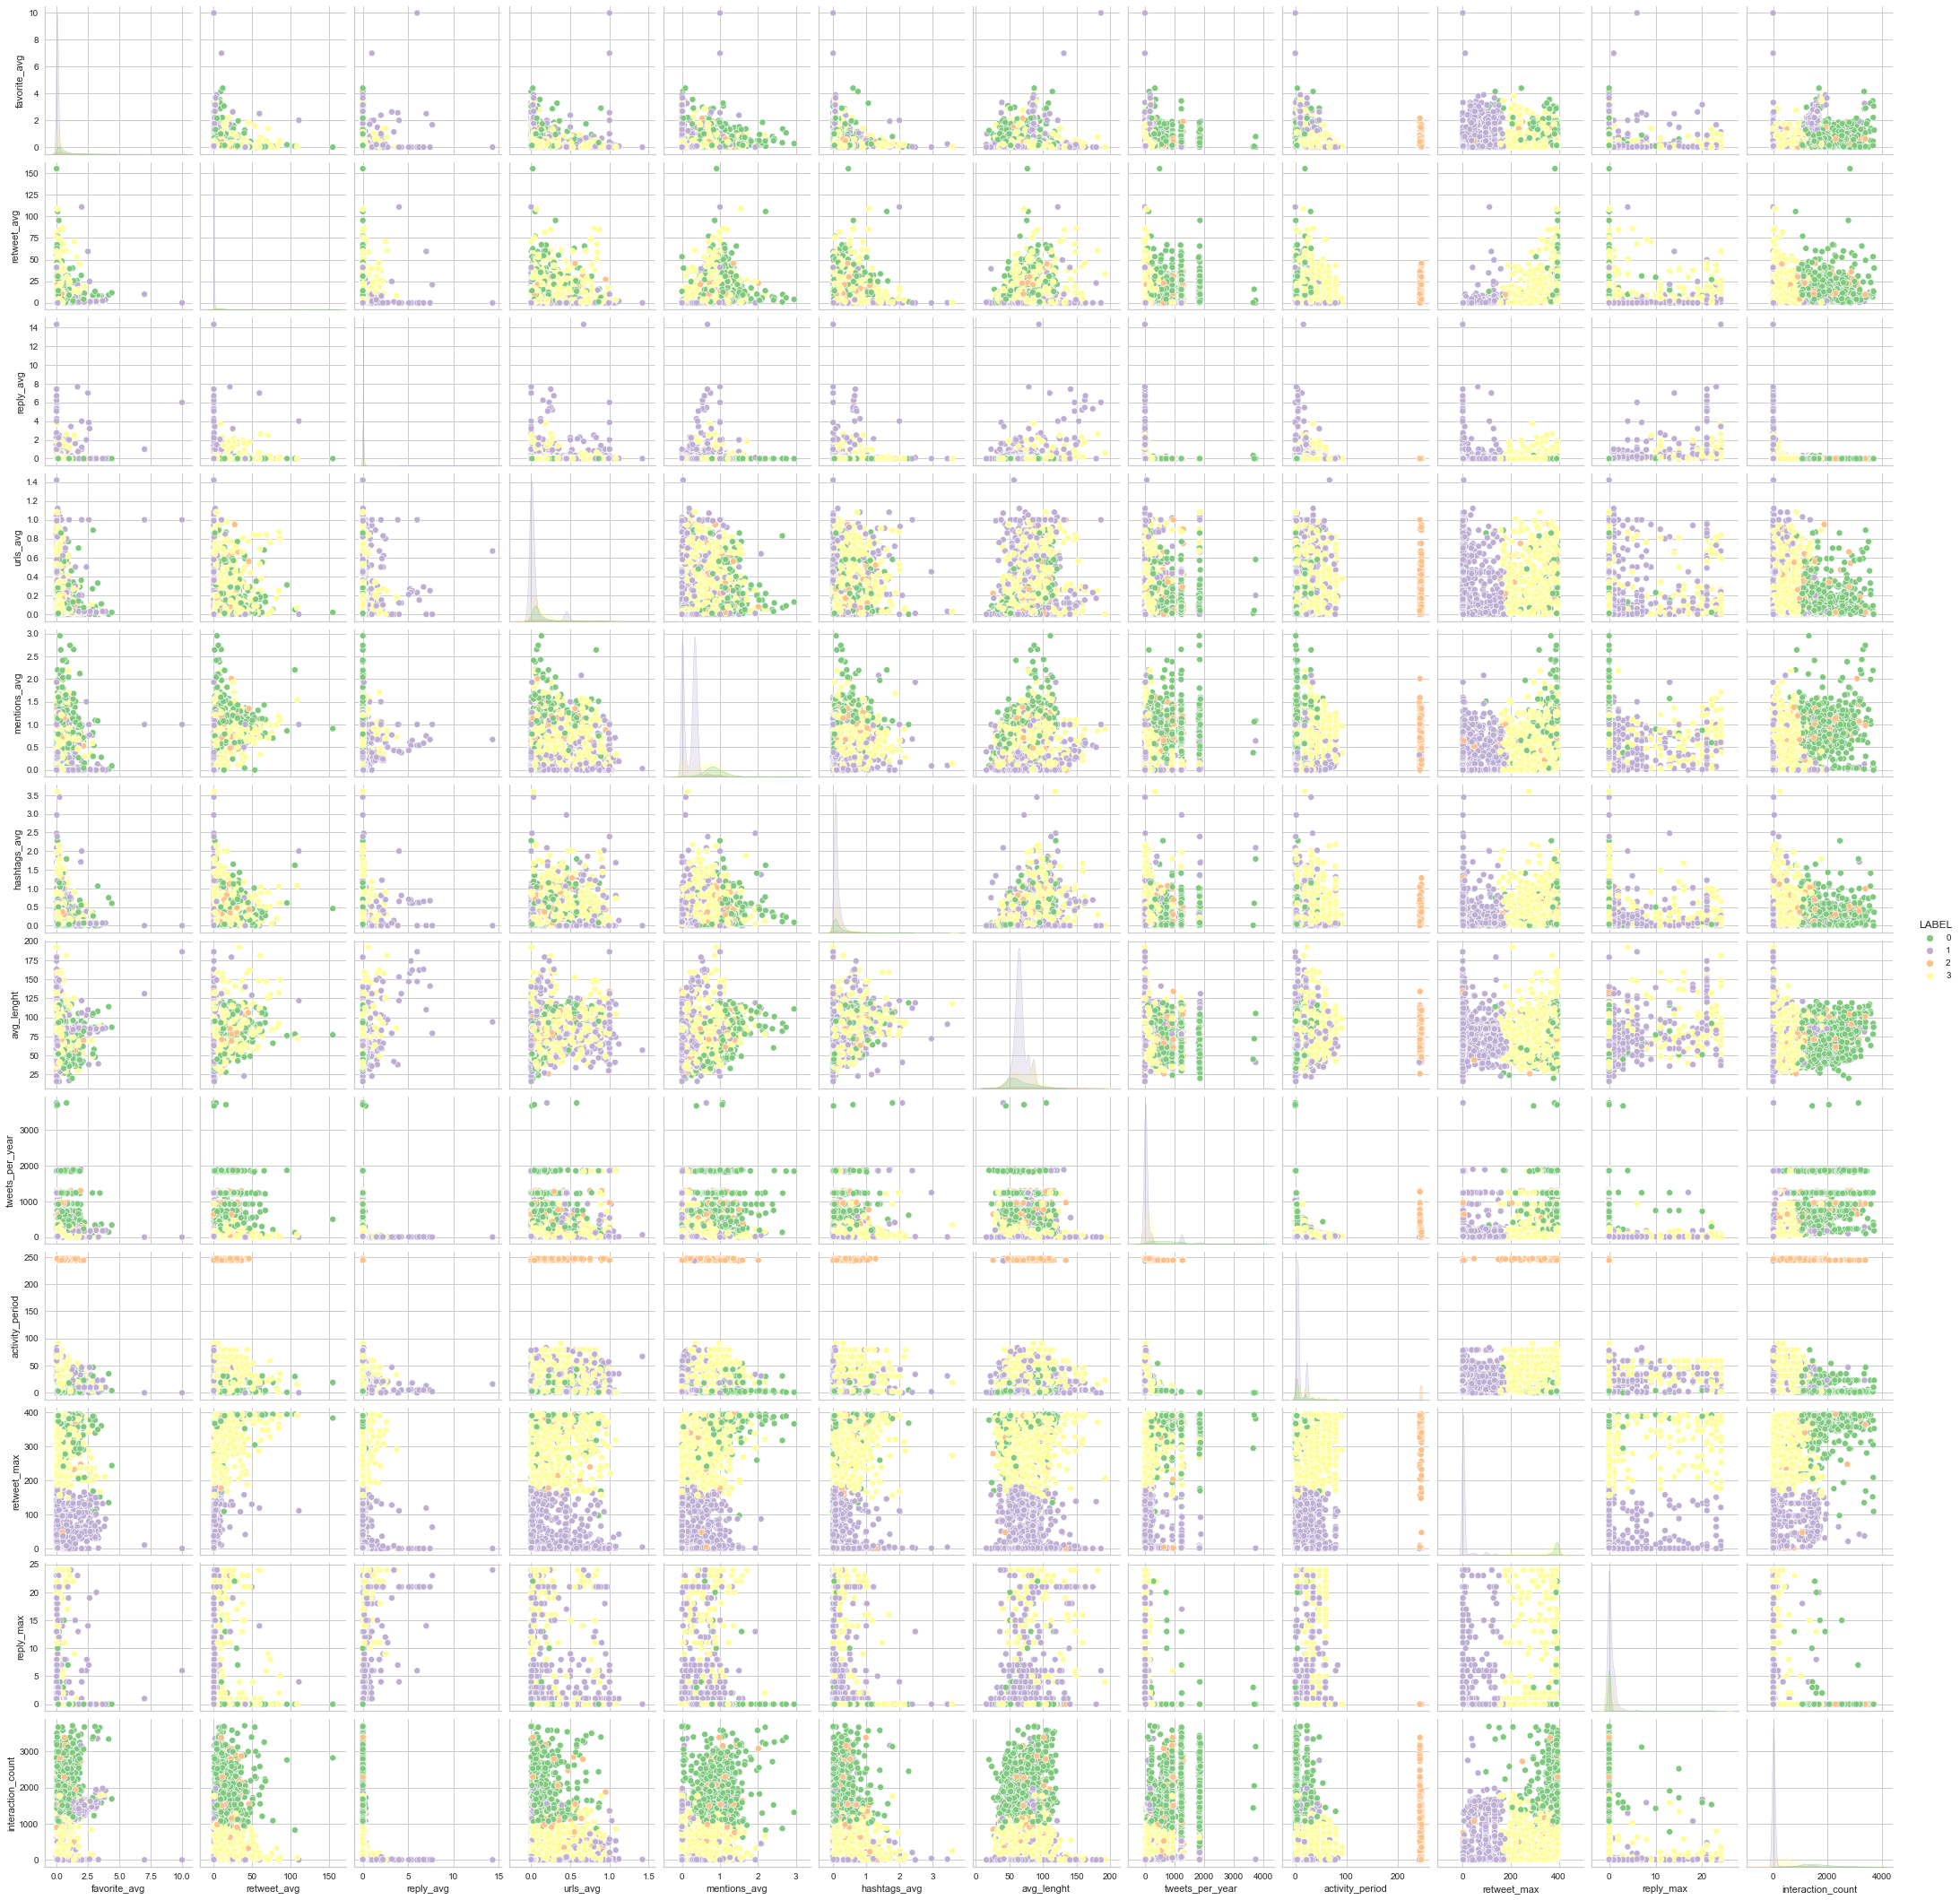

In [38]:
# Plot Clusters with Paiplot
cleaned_dataframe = users_clean.copy()
cleaned_dataframe["LABEL"] = kmeans.labels_  
# Pairplot
sns.pairplot(data=cleaned_dataframe, hue = "LABEL", palette = "Accent")